In [5]:
import numpy as np
import os
import cv2
import pandas as pd
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D
from keras.optimizers import RMSprop, Adam, Adadelta
from keras.layers import Input, Embedding, Dense, Dropout, Flatten
from keras.layers import Conv2D,MaxPooling2D,AveragePooling2D,BatchNormalization,GlobalAveragePooling2D
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.callbacks import ReduceLROnPlateau
import imutils
%matplotlib inline
import math
import matplotlib.pyplot
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.models import load_model
import seaborn as sns
import matplotlib.pyplot
image_size1 = 85
image_size2 = 128
from sklearn.model_selection import train_test_split,KFold
from sklearn.model_selection import cross_val_score
from keras import applications
from keras import backend as K
K.set_image_dim_ordering('th')

In [8]:
def load_train(simul):
    X_train = []
    y_train = []
    train_ds = pd.read_csv('Train.csv')
    print('Read train images')
    for index, row in train_ds.iterrows():
        image_path = os.path.join('TrainPictures', str(row['Image_Name']) + '.jpg')
        img = cv2.resize(cv2.imread(image_path,cv2.IMREAD_COLOR), (image_size1,image_size2)).astype(np.float32)
        img = img.transpose((2,0,1))
        X_train.append(img)
        if simul == 0:
            y_train.append(row['Competency_Score'])
        elif simul == 1:
            y_train.append(row['Trustworthy_Score'])
        else:    
            y_train.append([row['Competency_Score'],row['Trustworthy_Score']])         
    return X_train, y_train  

def read_and_normalize_train_data(simul,k= 3):
    train_data, train_target = load_train(simul)       
    train_data = np.array(train_data, dtype=np.float32)
    train_target = np.array(train_target, dtype=np.float32)
    print("Train data shape",train_data.shape)
    print("Train target shape",train_target.shape)
    print(train_data.shape[0], 'train samples')
    return train_data, train_target

# Image generators
def imagegen(config):
    if config == 1:
        datagen = ImageDataGenerator(
        rotation_range=120,
        zoom_range=0.40,
        horizontal_flip=True,
        fill_mode='nearest',
        rescale=1./255,
        validation_split = 0.9)
    elif config == 2:
        datagen = ImageDataGenerator(
        featurewise_center=True,
        featurewise_std_normalization=True,
        rotation_range=120,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest',
        rescale=1./255,
        validation_split = 0.9)
    elif config ==3:
        datagen = ImageDataGenerator(horizontal_flip = True,
                         vertical_flip = True,
                         rescale=1./255,
                         width_shift_range = 0.1,
                         height_shift_range = 0.1,
                         zoom_range = 0.1,
                         rotation_range = 10)
    return datagen 

def create_model(config,output):
    if config == 1:
        input_layer = Input(shape=(3,image_size2,image_size1))
        x = Conv2D(16, 3, activation='relu')(input_layer)
        x = MaxPooling2D(pool_size=2,data_format="channels_first")(x)
        x = Conv2D(32, 3, activation='relu')(x)
        x = MaxPooling2D(pool_size=2,data_format="channels_first")(x)
        x = Conv2D(64,3,activation='relu')(x)
        x = MaxPooling2D(pool_size=2,data_format="channels_first")(x) 
        x = Flatten()(x)     
        x = Dense(500, activation='relu')(x)
        x = Dropout(0.5)(x)
        x = Dense(100, activation='relu')(x)
        x = Dropout(0.25)(x)
        x = Dense(20, activation='relu')(x)
        if output == 1:
            output_layer = Dense(1, activation='relu')(x)
        elif output == 2:
            output_layer = Dense(2, activation='relu')(x)
        model = Model(input_layer, output_layer)
        model.compile(loss='mean_squared_error', optimizer=Adam(), metrics=['mae'])
        return model
    elif config == 2: 
        input_layer = Input(shape=(3,image_size2,image_size1))
        x = Conv2D(32, 3, activation='relu')(input_layer)
        x = MaxPooling2D(pool_size=2,data_format="channels_first")(x)
        x = Flatten()(x)     
        x = Dense(256, activation='relu')(x)
        x = Dropout(0.2)(x)
        x = Dense(64, activation='relu')(x)
        x = Dropout(0.2)(x)
        x = Dense(128, activation='relu')(x)
        x = Dropout(0.2)(x)
        if output == 1:
            output_layer = Dense(1, activation='relu')(x)
        elif output == 2:
            output_layer = Dense(2, activation='relu')(x)
        model = Model(input_layer, output_layer)
        model.compile(loss='mean_absolute_error', optimizer=Adam(), metrics=['mae'])
        return model
    elif config == 3:
        input_layer = Input(shape=(3,image_size2,image_size1))
        x = Conv2D(32, 3, activation='relu')(input_layer)
        x = MaxPooling2D(pool_size=2,data_format="channels_first")(x)       
#         x = BatchNormalization(axis= 3)  
        x = Conv2D(64, 3, activation='relu')(x)
        x = MaxPooling2D(pool_size=2,data_format="channels_first")(x)        
#         x = BatchNormalization(axis= 3)    
        x = Conv2D(128, 3, activation='relu')(x)
        x = MaxPooling2D(pool_size=2,data_format="channels_first")(x)        
#         x = BatchNormalization(axis = 3)(x)
        x = Conv2D(64, 3, activation='relu')(x)
        x = GlobalAveragePooling2D()(x)
        if output == 1:
            output_layer = Dense(1, activation='relu')(x)
        elif output == 2:
            output_layer = Dense(2, activation='relu')(x)
        model = Model(input_layer, output_layer)
        model.compile(loss='mean_absolute_error', optimizer=Adam(), metrics=['mae'])       
        return model
    elif config == 4:
        input_layer = Input(shape=(3,image_size2,image_size1))
        x = Conv2D(16, 3, activation='relu')(input_layer)
        x = MaxPooling2D(pool_size=2,data_format="channels_first")(x)       
        x = Conv2D(32, 3, activation='relu')(x)
        x = MaxPooling2D(pool_size=2,data_format="channels_first")(x)         
        x = Conv2D(64, 3, activation='relu')(x)
        x = MaxPooling2D(pool_size=2,data_format="channels_first")(x)        
        x = Conv2D(128, 3, activation='relu')(x)
        x = MaxPooling2D(pool_size=2,data_format="channels_first")(x) 
        x = Conv2D(64, 3, activation='relu')(x)
        x = Flatten()(x) 
        x = Dropout(0.5)(x)
        x = Dense(512, activation='relu')(x)
        if output == 1:
            output_layer = Dense(1, activation='relu')(x)
        elif output == 2:
            output_layer = Dense(2, activation='relu')(x)
        model = Model(input_layer, output_layer)
        model.compile(loss='mean_absolute_error', optimizer=Adam(), metrics=['mae'])       
        return model
    elif config == 5:
        base_model = applications.resnet50.ResNet50(weights= None, include_top=False, input_shape= (3,image_size2,image_size1))
        x = base_model.output
        x = GlobalAveragePooling2D()(x)
        x = Dropout(0.7)(x)
        if output == 1:
            output_layer = Dense(1, activation='relu')(x)
        elif output == 2:
            output_layer = Dense(2, activation='relu')(x)
        model = Model(inputs = base_model.input, outputs = output_layer)
        model.compile(loss='mean_absolute_error', optimizer=Adam(), metrics=['mae'])       
        return model
def get_callbacks(name_weights, patience_lr,patience_es):
    mcp_save = ModelCheckpoint(name_weights,verbose=1,save_best_only=True, monitor='val_loss', mode='min')
    earlystopping = EarlyStopping(monitor='val_loss',patience=patience_es, verbose=1, mode='min', restore_best_weights=True)
    reduce_lr_loss = ReduceLROnPlateau(monitor='loss', factor=0.1, patience=patience_lr, verbose=1, min_delta=1e-4, mode='min')
    return [mcp_save, reduce_lr_loss,earlystopping]

# Simultaneous Regression

In [9]:
x,y = read_and_normalize_train_data(simul = None)
kfold = KFold(n_splits=5, shuffle=True, random_state=1)
model = create_model(config = 5,output = 2)
for j, (train_idx, val_idx) in enumerate(kfold.split(x,y)): 
    batch_size=64
    print('\nFold ',j)
    X_train_cv = x[train_idx]
    y_train_cv = y[train_idx]
    X_valid_cv = x[val_idx]
    y_valid_cv= y[val_idx] 
    STEP_SIZE_TRAIN=len(X_train_cv)//batch_size
    STEP_SIZE_VALID=len(X_valid_cv)//batch_size
    name_weights = "final_model_fold" + str(j) + "_weights.h5"
    callbacks = get_callbacks(name_weights = name_weights, patience_lr=5,patience_es = 5)
    gen = imagegen(1)
    datagen_v = ImageDataGenerator(rescale=1./255)
    gen.fit(X_train_cv)
    generator = gen.flow(X_train_cv, y_train_cv, batch_size = 100)
    generator_v = datagen_v.flow(X_valid_cv, y_valid_cv, batch_size = 100)
    model.fit_generator(
                generator,
                steps_per_epoch=STEP_SIZE_TRAIN,
                epochs=10,
                shuffle=True,
                verbose=1,
                validation_data = generator_v,
                validation_steps=STEP_SIZE_VALID,
                callbacks = callbacks)
    print(model.metrics_names)
    print(model.evaluate_generator(generator=generator_v,steps=STEP_SIZE_VALID))

Read train images
Train data shape (800, 3, 128, 85)
Train target shape (800, 2)
800 train samples


/anaconda3/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '



Fold  0
Epoch 1/10
10/10 [==============================] - 1352s 135s/step - loss: 2.9926 - mean_absolute_error: 2.9926 - val_loss: 6.1821 - val_mean_absolute_error: 6.1821

Epoch 00001: val_loss improved from inf to 6.18206, saving model to final_model_fold0_weights.h5
Epoch 2/10
10/10 [==============================] - 835s 84s/step - loss: 2.3226 - mean_absolute_error: 2.3226 - val_loss: 6.1493 - val_mean_absolute_error: 6.1493

Epoch 00002: val_loss improved from 6.18206 to 6.14935, saving model to final_model_fold0_weights.h5
Epoch 3/10
10/10 [==============================] - 826s 83s/step - loss: 2.0978 - mean_absolute_error: 2.0978 - val_loss: 6.0434 - val_mean_absolute_error: 6.0434

Epoch 00003: val_loss improved from 6.14935 to 6.04338, saving model to final_model_fold0_weights.h5
Epoch 4/10
10/10 [==============================] - 868s 87s/step - loss: 2.0583 - mean_absolute_error: 2.0583 - val_loss: 6.0116 - val_mean_absolute_error: 6.0116

Epoch 00004: val_loss improved

Epoch 3/10
10/10 [==============================] - 1920s 192s/step - loss: 1.7622 - mean_absolute_error: 1.7622 - val_loss: 3.6664 - val_mean_absolute_error: 3.6664

Epoch 00003: val_loss did not improve from 1.59407
Epoch 4/10
10/10 [==============================] - 740s 74s/step - loss: 1.7170 - mean_absolute_error: 1.7170 - val_loss: 4.1033 - val_mean_absolute_error: 4.1033

Epoch 00004: val_loss did not improve from 1.59407
Epoch 5/10
10/10 [==============================] - 688s 69s/step - loss: 1.8366 - mean_absolute_error: 1.8366 - val_loss: 4.8562 - val_mean_absolute_error: 4.8562

Epoch 00005: val_loss did not improve from 1.59407
Epoch 6/10
10/10 [==============================] - 766s 77s/step - loss: 1.8789 - mean_absolute_error: 1.8789 - val_loss: 6.3723 - val_mean_absolute_error: 6.3723

Epoch 00006: val_loss did not improve from 1.59407
Epoch 7/10
10/10 [==============================] - 787s 79s/step - loss: 1.8428 - mean_absolute_error: 1.8428 - val_loss: 4.8802 - va

In [10]:
#Unknown Predictions
test_ds = pd.read_csv('Test_p.csv')
#Predictions
x =[]
y=[]
for index, row in test_ds.iterrows():
        image_path = os.path.join('TrainPictures', str(row['Image_Name']) + '.jpg')
        img = cv2.resize(cv2.imread(image_path,cv2.IMREAD_COLOR), (image_size1,image_size2)).astype(np.float32)
        img = img.reshape( (1,3,128, 85) )
        img = img / 255
        a  = model.predict(img)
        x.append(str(row['Image_Name']) + '.jpg')
        y.append(a) 
# Test Results
a = np.array(y)
a = a.reshape(-1,2)
df_results = pd.DataFrame()
df_results['Image_Name'] = x
df_results['Combined Test Score'] = y
df_results[['Competency_Score_P','Trustworthy_Score_P']] = pd.DataFrame(a)
df_results['Competency_Score_P'] = round(df_results['Competency_Score_P'], 2)
df_results['Trustworthy_Score_P'] = round(df_results['Trustworthy_Score_P'], 2)
df_results['Competency_Score_A'] = test_ds['Competency_Score']
df_results['Trustworthy_Score_A'] = test_ds['Trustworthy_Score']
df_results = df_results[['Image_Name', 'Competency_Score_P', 'Trustworthy_Score_P','Competency_Score_A','Trustworthy_Score_A']]
print(df_results.head(5))  
mae_comp = np.sum(np.absolute(df_results['Competency_Score_P'] - df_results['Competency_Score_A']))/len(df_results)
mae_trust = np.sum(np.absolute(df_results['Trustworthy_Score_P'] - df_results['Trustworthy_Score_A']))/len(df_results)
print("MAE Competency:", mae_comp)
print("MAE Trustworthy:", mae_trust)
print("MAE Combined:", mae_trust+mae_comp)

  Image_Name  Competency_Score_P  Trustworthy_Score_P  Competency_Score_A  \
0   B268.jpg                5.64            12.720000                3.00   
1   B287.jpg                6.06             5.360000                8.00   
2   B467.jpg                1.58            19.440001                7.67   
3   B506.jpg                3.05            16.020000                5.88   
4   B292.jpg                0.00            21.290001                9.00   

   Trustworthy_Score_A  
0                 5.00  
1                 2.50  
2                 6.67  
3                 5.62  
4                 9.00  
MAE Competency: 2.730373113612408
MAE Trustworthy: 7.279403041298709
MAE Combined: 10.009776154911117


In [8]:
#Test Predictions
test_ds = pd.read_csv('TestSamples.csv')
#Predictions
x =[]
y=[]
for index, row in test_ds.iterrows():
        image_path = os.path.join('TestPictures', str(row['Image_Name']) + '.jpg')
        img = cv2.resize(cv2.imread(image_path,cv2.IMREAD_COLOR), (image_size1,image_size2)).astype(np.float32)
        img = img.reshape( (1,3,128, 85) )
        img = img / 255
        a  = model.predict(img)
        x.append(str(row['Image_Name']) + '.jpg')
        y.append(a) 
# Test Results
a = np.array(y)
a = a.reshape(-1,2)
df_results = pd.DataFrame()
df_results['Image_Name'] = x
df_results['Combined Test Score'] = y
df_results[['Competency_Score_P','Trustworthy_Score_P']] = pd.DataFrame(a)
df_results['Competency_Score_P'] = round(df_results['Competency_Score_P'], 2)
df_results['Trustworthy_Score_P'] = round(df_results['Trustworthy_Score_P'], 2)

In [9]:
df_results

,Image_Name,Combined Test Score,Competency_Score_P,Trustworthy_Score_P
0,B393.jpg,"[[7.699521, 7.0252566]]",7.70,7.03
1,B829.jpg,"[[7.8907447, 7.2430067]]",7.89,7.24
2,B29.jpg,"[[6.929843, 6.310517]]",6.93,6.31
3,B916.jpg,"[[7.384675, 6.7183995]]",7.38,6.72
4,B251.jpg,"[[7.478967, 6.765052]]",7.48,6.77
5,B371.jpg,"[[7.0157776, 6.3681483]]",7.02,6.37
6,B463.jpg,"[[7.1571503, 6.544732]]",7.16,6.54
7,B284.jpg,"[[7.409048, 6.7671294]]",7.41,6.77
8,B886.jpg,"[[8.774618, 8.035471]]",8.77,8.04
9,B478.jpg,"[[7.191312, 6.620974]]",7.19,6.62


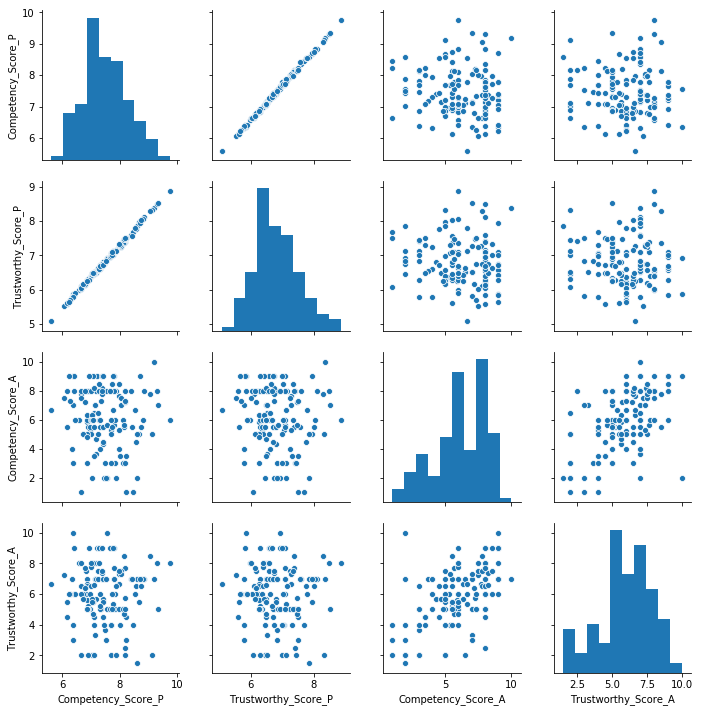

In [5]:
sns.pairplot(df_results)

# Individual Regression - Only on Competency Score

In [88]:
cv_size = 50
x,y = read_and_normalize_train_data(simul = 0)
kfold = KFold(n_splits=5, shuffle=True, random_state=1)
for j, (train_idx, val_idx) in enumerate(kfold.split(x,y)): 
    batch_size=64
    print('\nFold ',j)
    X_train_cv = x[train_idx]
    y_train_cv = y[train_idx]
    X_valid_cv = x[val_idx]
    y_valid_cv= y[val_idx] 
    STEP_SIZE_TRAIN=len(X_train_cv)//batch_size
    STEP_SIZE_VALID=len(X_valid_cv)//batch_size
    name_weights = "final_model_fold" + str(j) + "_weights.h5"
    callbacks = get_callbacks(name_weights = name_weights, patience_lr=5,patience_es = 10)
    gen = imagegen(3)
    datagen_v = ImageDataGenerator(rescale=1./255)
    gen.fit(X_train_cv)
    generator = gen.flow(X_train_cv, y_train_cv, batch_size = 50)
    generator_v = datagen_v.flow(X_valid_cv, y_valid_cv, batch_size = 50)
    model.fit_generator(
                generator,
                steps_per_epoch=STEP_SIZE_TRAIN,
                epochs=10,
                shuffle=True,
                verbose=1,
                validation_data = generator_v,
                validation_steps=STEP_SIZE_VALID,
                callbacks = callbacks)
    print(model.metrics_names)
    print(model.evaluate_generator(generator=generator_v,steps=STEP_SIZE_VALID))

Read train images
Train data shape (800, 3, 128, 85)
Train target shape (800,)
800 train samples

Fold  0
Epoch 1/5


ValueError: Error when checking target: expected dense_60 to have shape (2,) but got array with shape (1,)

In [ ]:
#Unknown Predictions
test_ds = pd.read_csv('Test_p.csv')
#Predictions
x =[]
y=[]
for index, row in test_ds.iterrows():
        image_path = os.path.join('TrainPictures', str(row['Image_Name']) + '.jpg')
        img = cv2.resize(cv2.imread(image_path,cv2.IMREAD_COLOR), (image_size1,image_size2)).astype(np.float32)
        img = img.reshape( (1,3,128, 85) )
        img = img / 255
        a  = model.predict(img)
        x.append(str(row['Image_Name']) + '.jpg')
        y.append(a) 
# Test Results
a = np.array(y)
a = a.reshape(-1,1)
df_results = pd.DataFrame()
df_results['Image_Name'] = x
df_results['Combined Test Score'] = y
df_results[['Competency_Score_P']] = pd.DataFrame(a)
df_results['Competency_Score_P'] = round(df_results['Competency_Score_P'], 2)
df_results['Competency_Score_A'] = test_ds['Competency_Score']
df_results = df_results[['Image_Name', 'Competency_Score_P','Competency_Score_A']]
print(df_results.head(5))
mae_comp = np.sum(np.absolute(df_results['Competency_Score_P'] - df_results['Competency_Score_A']))
mae_trust = np.sum(np.absolute(df_results['Trustworthy_Score_P'] - df_results['Trustworthy_Score_A']))
print("MAE Competency:", mae_comp)
print("MAE Trustworthy:", mae_trust)
print("MAE Combined:", mae_trust+mae_comp)

In [ ]:
sns.pairplot(df_results)

# Individual Regression - Only on Trustworthy Score

In [ ]:
cv_size = 50
x,y = read_and_normalize_train_data(simul = 1)
kfold = KFold(n_splits=5, shuffle=True, random_state=1)
for j, (train_idx, val_idx) in enumerate(kfold.split(train_data, train_target)): 
    batch_size=64
    print('\nFold ',j)
    X_train_cv = x[train_idx]
    y_train_cv = y[train_idx]
    X_valid_cv = x[val_idx]
    y_valid_cv= y[val_idx] 
    name_weights = "final_model_fold" + str(j) + "_weights.h5"
    callbacks = get_callbacks(name_weights = name_weights, patience_lr=5,patience_es = 10)
    gen = imagegen(3)
    datagen_v = ImageDataGenerator(rescale=1./255)
    gen.fit(X_train_cv)
    STEP_SIZE_TRAIN=len(X_train_cv)//batch_size
    STEP_SIZE_VALID=len(X_valid_cv)//batch_size
    generator = gen.flow(X_train_cv, y_train_cv, batch_size = 100)
    generator_v = datagen_v.flow(X_valid_cv, y_valid_cv, batch_size = 100)
    model.fit_generator(
                generator,
                steps_per_epoch=STEP_SIZE_TRAIN,
                epochs=5,
                shuffle=True,
                verbose=1,
                validation_data = generator_v,
                validation_steps=STEP_SIZE_VALID,
                callbacks = callbacks)
    print(model.metrics_names)
    print(model.evaluate_generator(generator=generator_v,steps=STEP_SIZE_VALID))

In [ ]:
#Unknown Predictions
test_ds = pd.read_csv('Test_p.csv')
#Predictions
x =[]
y=[]
for index, row in test_ds.iterrows():
        image_path = os.path.join('TrainPictures', str(row['Image_Name']) + '.jpg')
        img = cv2.resize(cv2.imread(image_path,cv2.IMREAD_COLOR), (image_size1,image_size2)).astype(np.float32)
        img = img.reshape( (1,3,128, 85) )
        img = img / 255
        a  = model.predict(img)
        x.append(str(row['Image_Name']) + '.jpg')
        y.append(a) 
# Test Results
a = np.array(y)
a = a.reshape(-1,1)
df_results = pd.DataFrame()
df_results['Image_Name'] = x
df_results['Combined Test Score'] = y
df_results[['Trustworthy_Score_P']] = pd.DataFrame(a)
df_results['Trustworthy_Score_P'] = round(df_results['Trustworthy_Score_P'], 2)
df_results['Trustworthy_Score_A'] = test_ds['Trustworthy_Score']
df_results = df_results[['Image_Name', 'Trustworthy_Score_P','Trustworthy_Score_A']]
print(df_results.head(5))

In [ ]:
sns.pairplot(df_results)